# **Identifying Fraudulent Job Postings**
by  
## Candice Chiang and Brandon Wallace
## wantienc & blwallac [@] andrew.cmu.edu
## Carnegie Mellon University

### **Sections:** 
  
#### 1. Data Cleaning  
#### 2. Exploratory Data Analysis  
#### 3. Sampling  
#### 4. Splitting
#### 5. Feature Engineering  
#### 6. Machine Learning 

### **Overview** 
Using publicly available information on a standard job-board website, we developed an approach to successfully identify fraudulent job postings 95% of the time with 63% percent recall. Our objective was to identify the rare cases of scams on job boards to flag them in the future for content moderators.  
    
Graduate students in professional programs are actively seeking post-graudate opportunities. For most students, this is a stressful process that requires sifting through dozens of online job boards and websites containing thousands of postings relevant to their feild of study. [The Federal Trade Commission estaimted](https://www.cnbc.com/2022/06/10/americans-lost-68-million-to-job-scams-this-year-here-are-the-most-common-ones.html) that Americans lost $68 million in scams due to fake business and job opportunities in 2022. These scams can be even more pronounced for international students who are unfamiliar with domestic job boards and face incredible pressure to secure a job which can sponosor their continued stay in country. This solution helps job board websites understand how compromised their content is which ultimately protects job seekers from criminals.   
  
Fraudulent jobs expose individuals to scams. This can result in monetary damages but also important unseen costs in lost personally identifying information. Fraudulent jobs also negatively impact the reputation of job boards designed by companies who are trying to provide a valuable product. Lastly, fraudulent jobs present challenges for governments as well who support job-seekers and unemployed individuals with costly benefits programs.

  
This notebook contains the full process. We discover abstract topics from job descriptions using Latent Dirichlet Allocation(LDA) and then utilize supervised learning with a lableled dataset to predict whether a job is fraudulent or legitimate with a random forest algorithm also employing Synthetic Minority Oversampling Technique (SMOTE) for unbalanced classes. 


### Data Cleaning

> This project utilizes a data set [from the University of the Aegean](https://emscad.samos.aegean.gr/). This data set, titled "Employment Scam Aegean Dataset" contains 17,014 legitimate and 866 fraudulent job ads published between 2012 to 2014, across multiple countries.

The data contains string fields containing basic information like descriptions, titles, locations, and salary ranges; binary fields such as telecomuting options, presence of logos, and fraudulent status; as well as nominbal fields representing industry, emploement type, and education requirements. These fields are features -- relative to our target, fraudulent status.

This section details our initial data processing. We remove all HTML all create and start transforming all fields to meaningful numeric values.

In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
# Importing data from file
jobs_df = pd.read_csv('/emscad_v1.csv')
jobs_df.head(5)

title            location department  \
0                           Marketing Intern    US, NY, New York  Marketing   
1  Customer Service - Cloud Video Production      NZ, , Auckland    Success   
2    Commissioning Machinery Assistant (CMA)       US, IA, Wever        NaN   
3          Account Executive - Washington DC  US, DC, Washington      Sales   
4                        Bill Review Manager  US, FL, Fort Worth        NaN   

  salary_range                                    company_profile  \
0          NaN  <h3>We're Food52, and we've created a groundbr...   
1          NaN  <h3>90 Seconds, the worlds Cloud Video Product...   
2          NaN  <h3></h3>\r\n<p>Valor Services provides Workfo...   
3          NaN  <p>Our passion for improving quality of life t...   
4          NaN  <p>SpotSource Solutions LLC is a Global Human ...   

                                         description  \
0  <p>Food52, a fast-growing, James Beard Award-w...   
1  <p>Organised - Focused - Vibrant - Awesome!<br...   
2  <p>Our client, located in Houston, is actively...   
3  <p><b>THE COMPANY: ESRI – Environmental System...   
4  <p><b>JOB TITLE:</b> Itemization Review Manage...   

                                        requirements  \
0  <ul>\r\n<li>Experience with content management...   
1  <p><b>What we expect from you:</b></p>\r\n<p>Y...   
2  <ul>\r\n<li>Implement pre-commissioning and co...   
3  <ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...   
4  <p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...   

                                            benefits telecommuting  \
0                                                NaN             f   
1  <h3><b>What you will get from us</b></h3>\r\n<...             f   
2                                                NaN             f   
3  <p>Our culture is anything but corporate—we ha...             f   
4                       <p>Full Benefits Offered</p>             f   

  has_company_logo has_questions employment_type required_experience  \
0                t             f           Other          Internship   
1                t             f       Full-time      Not Applicable   
2                t             f             NaN                 NaN   
3                t             f       Full-time    Mid-Senior level   
4                t             t       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

  fraudulent in_balanced_dataset  
0          f                   f  
1          f                   f  
2          f                   f  
3          f                   f  
4          f                   f

In [ ]:
# Checking basic structure 

jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [ ]:
jobs_df.describe()

title         location department salary_range  \
count                     17880            17534       6333         2868   
unique                    11231             3105       1337          874   
top     English Teacher Abroad   GB, LND, London      Sales          0-0   
freq                        311              718        551          142   

                                          company_profile  \
count                                               14572   
unique                                               1710   
top     <p>We help teachers get safe &amp; secure jobs...   
freq                                                  726   

                                              description  \
count                                               17880   
unique                                              15095   
top     <p>Play with kids, get paid for it </p>\r\n<p>...   
freq                                                  376   

                                             requirements  \
count                                               15191   
unique                                              12119   
top     <p>University degree required. TEFL / TESOL / ...   
freq                                                  410   

                          benefits telecommuting has_company_logo  \
count                        10684         17880            17880   
unique                        6510             2                2   
top     <p>See job description</p>             f                t   
freq                           726         17113            14220   

       has_questions employment_type required_experience required_education  \
count          17880           14409               10830               9775   
unique             2               5                   7                 13   
top                f       Full-time    Mid-Senior level  Bachelor's Degree   
freq            9088           11620                3809               5145   

                                   industry                function  \
count                                 12977                   11425   
unique                                  131                      37   
top     Information Technology and Services  Information Technology   
freq                                   1734                    1749   

       fraudulent in_balanced_dataset  
count       17880               17880  
unique          2                   2  
top             f                   f  
freq        17014               16980

In [ ]:
# Checking for missing values

jobs_df.isna().any()[lambda x: x]

location               True
department             True
salary_range           True
company_profile        True
requirements           True
benefits               True
employment_type        True
required_experience    True
required_education     True
industry               True
function               True
dtype: bool

In [ ]:
jobs_df.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64

#### Cleaning by Column

In [ ]:
# Extracting a Country from Location

jobs_df['country'] = jobs_df['location'].str[:2]

In [ ]:
# Extracting State if present

# using regex to pull the abbreviation since it can occur right after US or after space
# the expression evaluates to any two capital characters after US appears
jobs_df['state'] = jobs_df['location'].str.extract(r'(US, ([A-Z]{2}),)')[1]

In [ ]:
# Creating a min and max value for salary range

jobs_df[['minimum_salary', 'maximum_salary']] = jobs_df['salary_range'].str.split('-', expand=True)
jobs_df['minimum_salary'] = pd.to_numeric(jobs_df['minimum_salary'])
jobs_df['maximum_salary'] = pd.to_numeric(jobs_df['maximum_salary'])

In [ ]:
# Removing all HTML formatting from copy

html_pattern = r'<.*?>'
non_english_pattern = r"\b(?![a-zA-Z']+)[^\W\d_]+\b"

jobs_df['company_profile'] = jobs_df['company_profile'].str.replace(html_pattern, '', regex=True)
jobs_df['company_profile'] = jobs_df['company_profile'].str.replace('\r', '').str.replace('\n', '')
jobs_df['company_profile'] = jobs_df['company_profile'].str.replace(non_english_pattern, '', regex=True)

jobs_df['description'] = jobs_df['description'].str.replace(html_pattern, '', regex=True)
jobs_df['description'] = jobs_df['description'].str.replace('\r', '').str.replace('\n', '')
jobs_df['description'] = jobs_df['description'].str.replace(non_english_pattern, '', regex=True)

jobs_df['requirements'] = jobs_df['requirements'].str.replace(html_pattern, '', regex=True)
jobs_df['requirements'] = jobs_df['requirements'].str.replace('\r', '').str.replace('\n', '')
jobs_df['requirements'] = jobs_df['requirements'].str.replace(non_english_pattern, '', regex=True)

jobs_df['benefits'] = jobs_df['benefits'].str.replace(html_pattern, '', regex=True)
jobs_df['benefits'] = jobs_df['benefits'].str.replace('\r', '').str.replace('\n', '')
jobs_df['benefits'] = jobs_df['benefits'].str.replace(non_english_pattern, '', regex=True)


In [ ]:
# Transforming all t and f to 1 and 0 for ML algorithims

mapping = {'t': 1, 'f': 0}

jobs_df['telecommuting'] = jobs_df['telecommuting'].replace(mapping)
jobs_df['has_company_logo'] = jobs_df['has_company_logo'].replace(mapping)
jobs_df['fraudulent'] = jobs_df['fraudulent'].replace(mapping)
jobs_df['has_questions'] = jobs_df['has_questions'].replace(mapping)
jobs_df['in_balanced_dataset'] = jobs_df['in_balanced_dataset'].replace(mapping)

In [ ]:
# Checking Cleaned Formatting

column_order = ['fraudulent', 'title', 'location', 'country', 'state', 'department', 'function', 'industry', 'salary_range', 'minimum_salary', 'maximum_salary', 'telecommuting', 'company_profile', 'description',	'requirements', 'benefits', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education',]

jobs_df = jobs_df[column_order]

jobs_df.head(10)

fraudulent                                      title  \
0           0                           Marketing Intern   
1           0  Customer Service - Cloud Video Production   
2           0    Commissioning Machinery Assistant (CMA)   
3           0          Account Executive - Washington DC   
4           0                        Bill Review Manager   
5           0                           Accounting Clerk   
6           0                      Head of Content (m/f)   
7           0           Lead Guest Service Specialist      
8           0                                 HP BSM SME   
9           0    Customer Service Associate - Part Time    

                location country state  department              function  \
0       US, NY, New York      US    NY   Marketing             Marketing   
1         NZ, , Auckland      NZ   NaN     Success      Customer Service   
2          US, IA, Wever      US    IA         NaN                   NaN   
3     US, DC, Washington      US    DC       Sales                 Sales   
4     US, FL, Fort Worth      US    FL         NaN  Health Care Provider   
5               US, MD,       US    MD         NaN                   NaN   
6         DE, BE, Berlin      DE   NaN  ANDROIDPIT            Management   
7  US, CA, San Francisco      US    CA         NaN                   NaN   
8      US, FL, Pensacola      US    FL         NaN                   NaN   
9        US, AZ, Phoenix      US    AZ         NaN      Customer Service   

                              industry salary_range  minimum_salary  ...  \
0                                  NaN          NaN             NaN  ...   
1            Marketing and Advertising          NaN             NaN  ...   
2                                  NaN          NaN             NaN  ...   
3                    Computer Software          NaN             NaN  ...   
4               Hospital & Health Care          NaN             NaN  ...   
5                                  NaN          NaN             NaN  ...   
6                         Online Media  20000-28000         20000.0  ...   
7                                  NaN          NaN             NaN  ...   
8  Information Technology and Services          NaN             NaN  ...   
9                   Financial Services          NaN             NaN  ...   

   telecommuting                                    company_profile  \
0              0  We're Food52, and we've created a groundbreaki...   
1              0  90 Seconds, the worlds Cloud Video Production ...   
2              0  Valor Services provides Workforce Solutions th...   
3              0  Our passion for improving quality of life thro...   
4              0  SpotSource Solutions LLC is a Global Human Cap...   
5              0                                                NaN   
6              0  Founded in 2009, the Fonpit AG rose with its i...   
7              0  Airenvy’s mission is to provide lucrative yet ...   
8              0  Solutions3 is a woman-owned small business who...   
9              0  Novitex Enterprise Solutions, formerly Pitney ...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   
5  Job OverviewApex is an environmental consultin...   
6  Your Responsibilities: Manage the English-spea...   
7  Who is Airenvy?Hey there! We are seasoned entr...   
8  Implementation/Configuration/Testing/Training ...   
9  The Customer Service Associate will be based i...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, 

#### Exploratory Data Analysis


> This section details our exploration of the data and checking for errors which could influence the model. This dataset is highly unbalanced in our target value. We also find that the US is over-represented amongst job opportunities. We find that most jobs tend to be for full time work; for individuals with bachelor's degrees; for individuals at the mid-to-senior level of expereince. 



In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt 

<Axes: >

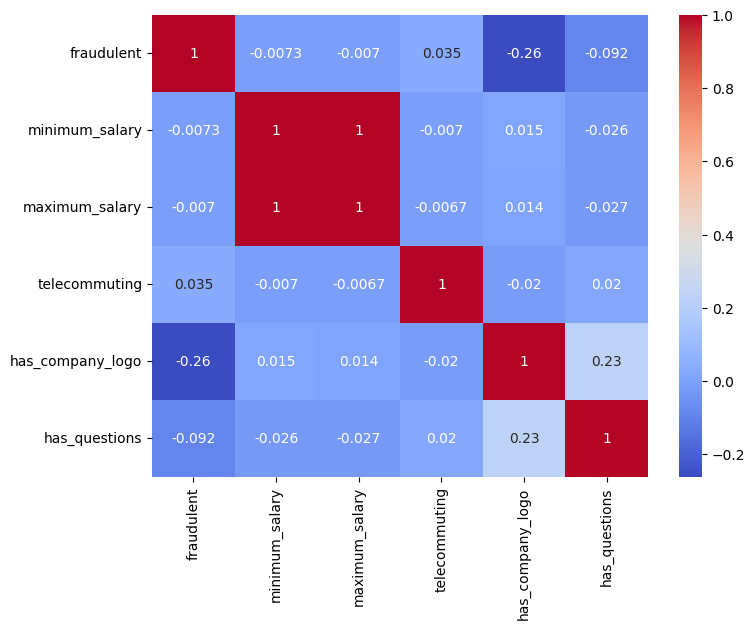

In [ ]:
# Checking correlation 

plt.figure(figsize=(8,6))
sns.heatmap(jobs_df.corr(), cbar=True, cmap='coolwarm', annot=True)

In [ ]:
# Changing altair default limit on rows

alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [ ]:
# Selecting only numerical columns 
binary_cols = jobs_df[['fraudulent','telecommuting', 'has_company_logo', 'has_questions']]

df_long = pd.melt(binary_cols, value_vars=binary_cols.columns)

# Checking distributions

chart = alt.Chart(df_long).mark_bar().encode(
    x=alt.X('value', bin=alt.Bin(maxbins=2)),
    y=alt.Y('count()', axis=alt.Axis(labelFontSize=16)),
    facet=alt.Facet('variable', columns=2, header=alt.Header(labelFontSize=16))
)

chart

alt.Chart(...)

In [ ]:
# Removing outliers and investigating salary ranges 

contin_cols = jobs_df[['minimum_salary','maximum_salary','salary_range']]
                      
contin_df = contin_cols.dropna()

Q1 = contin_df.quantile(0.25)
Q3 = contin_df.quantile(0.75)
IQR = Q3 - Q1
contin_df = contin_df[~((contin_df < (Q1 - 1.5 * IQR)) | (contin_df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Creating a scatter plot
scatter = alt.Chart(contin_df).mark_circle().encode(
    x='minimum_salary',
    y='maximum_salary',
    tooltip='salary_range'
).properties(
    width=600,
    height=400
)

scatter

C:\Users\wantienc\AppData\Local\Temp\ipykernel_15940\3617054113.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  contin_df = contin_df[~((contin_df < (Q1 - 1.5 * IQR)) | (contin_df > (Q3 + 1.5 * IQR))).any(axis=1)]


alt.Chart(...)

In [ ]:
# Checking the distribution by country 

count_by_country = jobs_df.groupby(['country'])[['fraudulent']].agg(['count'])
count_by_country = count_by_country.sort_values(by = [('fraudulent', 'count')], ascending=False)
count_by_country.head(10)

fraudulent
             count
country           
US           10656
GB            2384
GR             940
CA             457
DE             383
NZ             333
IN             276
AU             214
PH             132
NL             127

In [ ]:
bar_count = count_by_country.head(25)

flattened = bar_count.copy()
flattened.columns = flattened.columns.droplevel()
flattened = flattened.reset_index()

In [ ]:
# Visualizing country distribution

alt.Chart(flattened).mark_bar().encode(
    x='country',
    y='count'
)

alt.Chart(...)

In [ ]:
# Investigating only requirements 
level_df = jobs_df[['employment_type','required_experience', 'required_education']]
level_df = level_df.dropna()

e_type=alt.Chart(level_df).mark_bar().encode(
    x='count()',
    y='employment_type'
)

e_req=alt.Chart(level_df).mark_bar().encode(
    x='count()',
    y='required_experience'
)

edu_req=alt.Chart(level_df).mark_bar().encode(
    x='count()',
    y='required_education'
)

e_type | e_req | edu_req

alt.HConcatChart(...)

### Sampling



> This section details our sampling method. We check that the distribtuion of our sampled data matches the expectations we find in the exploration stage. 



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the target variable from the features
X = jobs_df.loc[:, jobs_df.columns != 'fraudulent']
y = jobs_df['fraudulent']

In [ ]:
# Splitting the training and testing sets before any transformation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, stratify=y)

#### Check the distribution of training data

In [ ]:
# Selecting only numerical columns 
binary_cols = X_train[['telecommuting', 'has_company_logo', 'has_questions']]

df_long = pd.melt(binary_cols, value_vars=binary_cols.columns)

# Checking distributions

chart = alt.Chart(df_long).mark_bar().encode(
    x=alt.X('value', bin=alt.Bin(maxbins=2)),
    y=alt.Y('count()', axis=alt.Axis(labelFontSize=16)),
    facet=alt.Facet('variable', columns=2, header=alt.Header(labelFontSize=16))
)

chart

alt.Chart(...)

In [ ]:
# Investigating only requirements 
level_df = X_train[['employment_type','required_experience', 'required_education']]
level_df = level_df.dropna()

e_type=alt.Chart(level_df).mark_bar().encode(
    x='count()',
    y='employment_type'
)

e_req=alt.Chart(level_df).mark_bar().encode(
    x='count()',
    y='required_experience'
)

edu_req=alt.Chart(level_df).mark_bar().encode(
    x='count()',
    y='required_education'
)

e_type | e_req | edu_req

alt.HConcatChart(...)

### Splitting Feature Engineering



> This section details how we construct meaningful features from the string based HTML data. We create bins of salaries to generate categories; we also create categories based on the description lengths and utilize a standard scalar technique as well as ordinal data from the requirements. For example, it is a higher order requirement to hold a Master's Degree as opposed to a lower order requirement to hold a High School Diploma. 



In [ ]:
# Setting the imputation for null values

def impute_cat_nan(df, col):
    df[col] = np.where(df[col].isnull(), 'Unknown', df[col])

In [ ]:
for col in ['country', 'state', 'department', 'function', 'industry', 'employment_type', 'required_experience', 'required_education']:
    impute_cat_nan(X_train, col)
    impute_cat_nan(X_test, col)

In [ ]:
# Cutting the continuous variables into bins 

X_train['minimum_salary_grp'] = pd.qcut(X_train['minimum_salary'], q=4)
X_train['minimum_salary_grp'].value_counts()

(35000.0, 60000.0]        522
(16625.0, 35000.0]        491
(-0.001, 16625.0]         479
(60000.0, 800000000.0]    422
Name: minimum_salary_grp, dtype: int64

In [ ]:
X_train['minimum_salary_grp'] = X_train['minimum_salary_grp'].cat.rename_categories({X_train['minimum_salary_grp'].cat.categories[0]: 0, X_train['minimum_salary_grp'].cat.categories[1]: 1, X_train['minimum_salary_grp'].cat.categories[2]: 2, X_train['minimum_salary_grp'].cat.categories[3]: 3})

In [ ]:
X_train['minimum_salary_grp'] = X_train['minimum_salary_grp'].cat.add_categories(-1)
X_train['minimum_salary_grp'].fillna(-1, inplace=True)
X_train['minimum_salary_grp'].unique()

[-1, 0, 3, 2, 1]
Categories (5, int64): [0 < 1 < 2 < 3 < -1]

In [ ]:
X_train['maximum_salary_grp'] = pd.qcut(X_train['maximum_salary'], q=4)
X_train['maximum_salary_grp'] = X_train['maximum_salary_grp'].cat.rename_categories({X_train['maximum_salary_grp'].cat.categories[0]: 0, X_train['maximum_salary_grp'].cat.categories[1]: 1, X_train['maximum_salary_grp'].cat.categories[2]: 2, X_train['maximum_salary_grp'].cat.categories[3]: 3})
X_train['maximum_salary_grp'] = X_train['maximum_salary_grp'].cat.add_categories(-1)
X_train['maximum_salary_grp'].fillna(-1, inplace=True)
X_train['maximum_salary_grp'].unique()

[-1, 0, 3, 2, 1]
Categories (5, int64): [0 < 1 < 2 < 3 < -1]

In [ ]:
X_train['company_profile_length'] = np.where(X_train['company_profile'].isnull(), 0, X_train['company_profile'].str.split().str.len())
X_train['description_length'] = np.where(X_train['description'].isnull(), 0, X_train['description'].str.split().str.len())
X_train['requirements_length'] = np.where(X_train['requirements'].isnull(), 0, X_train['requirements'].str.split().str.len())
X_train['benefits_length'] = np.where(X_train['benefits'].isnull(), 0, X_train['benefits'].str.split().str.len())

In [ ]:
X_test['maximum_salary_grp'] = pd.qcut(X_test['maximum_salary'], q=4)
X_test['maximum_salary_grp'] = X_test['maximum_salary_grp'].cat.rename_categories({X_test['maximum_salary_grp'].cat.categories[0]: 0, X_test['maximum_salary_grp'].cat.categories[1]: 1, X_test['maximum_salary_grp'].cat.categories[2]: 2, X_test['maximum_salary_grp'].cat.categories[3]: 3})
X_test['maximum_salary_grp'] = X_test['maximum_salary_grp'].cat.add_categories(-1)
X_test['maximum_salary_grp'].fillna(-1, inplace=True)
X_test['maximum_salary_grp'].unique()

[-1, 3, 2, 1, 0]
Categories (5, int64): [0 < 1 < 2 < 3 < -1]

In [ ]:
X_test['minimum_salary_grp'] = pd.qcut(X_test['minimum_salary'], q=4)
X_test['minimum_salary_grp'] = X_test['minimum_salary_grp'].cat.rename_categories({X_test['minimum_salary_grp'].cat.categories[0]: 0, X_test['minimum_salary_grp'].cat.categories[1]: 1, X_test['minimum_salary_grp'].cat.categories[2]: 2, X_test['minimum_salary_grp'].cat.categories[3]: 3})
X_test['minimum_salary_grp'] = X_test['minimum_salary_grp'].cat.add_categories(-1)
X_test['minimum_salary_grp'].fillna(-1, inplace=True)
X_test['minimum_salary_grp'].unique()

[-1, 3, 2, 1, 0]
Categories (5, int64): [0 < 1 < 2 < 3 < -1]

In [ ]:
X_test['company_profile_length'] = np.where(X_test['company_profile'].isnull(), 0, X_test['company_profile'].str.split().str.len())
X_test['description_length'] = np.where(X_test['description'].isnull(), 0, X_test['description'].str.split().str.len())
X_test['requirements_length'] = np.where(X_test['requirements'].isnull(), 0, X_test['requirements'].str.split().str.len())
X_test['benefits_length'] = np.where(X_test['benefits'].isnull(), 0, X_test['benefits'].str.split().str.len())

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[['company_profile_length', 'description_length', 'requirements_length', 'benefits_length']])

StandardScaler()

In [ ]:
X_train[['company_profile_length', 'description_length', 'requirements_length', 'benefits_length']] = scaler.transform(X_train[['company_profile_length', 'description_length', 'requirements_length', 'benefits_length']])

In [ ]:
X_test[['company_profile_length', 'description_length', 'requirements_length', 'benefits_length']] = scaler.transform(X_test[['company_profile_length', 'description_length', 'requirements_length', 'benefits_length']])

In [ ]:
employment_type_order = ['Unknown', 'Other', 'Temporary', 'Contract', 'Part-time', 'Full-time']
required_experience_order = ['Unknown', 'Not Applicable', 'Internship', 'Associate', 'Entry level', 'Mid-Senior level', 'Director', 'Executive']
required_education_order = ['Unknown', 'Unspecified', 'Some High School Coursework',  
                  'Some College Coursework Completed', 'Vocational - HS Diploma', 
                  'High School or equivalent', 'Certification', 'Vocational', 
                  'Associate Degree', "Bachelor's Degree", 'Vocational - Degree',
                  'Professional', "Master's Degree", 'Doctorate']

In [ ]:
X_train.employment_type = pd.Categorical(X_train.employment_type, categories=employment_type_order, ordered=True)
X_train.required_experience = pd.Categorical(X_train.required_experience, categories=required_experience_order, ordered=True)
X_train.required_education = pd.Categorical(X_train.required_education, categories=required_education_order, ordered=True)

In [ ]:
X_train.employment_type = X_train.employment_type.cat.codes
X_train.required_experience = X_train.required_experience.cat.codes
X_train.required_education = X_train.required_education.cat.codes
X_train.head()

title  \
2597                                      Brand Manager   
8235               PeopleSoft Quality Assurance Analyst   
3539  S1 2GH Recruitment Apprenticeship Available Un...   
6656                                   Backend Engineer   
3828                         Data Scientist (Part-Time)   

                       location country    state   department  \
2597        GR, B, Thessaloniki      GR  Unknown      Unknown   
8235  IN, KA, Domlur, Bangalore      IN  Unknown      Unknown   
3539                  GB, SHF,       GB  Unknown      Unknown   
6656           US, NY, New York      US       NY  Engineering   
3828              GR, I, Athens      GR  Unknown      Unknown   

                    function                             industry  \
2597                 Unknown                              Unknown   
8235  Information Technology  Information Technology and Services   
3539                 Unknown                              Unknown   
6656             Engineering                             Internet   
3828                 Unknown                              Unknown   

     salary_range  minimum_salary  maximum_salary  ...  has_questions  \
2597          NaN             NaN             NaN  ...              1   
8235          0-0             0.0             0.0  ...              0   
3539          NaN             NaN             NaN  ...              0   
6656          NaN             NaN             NaN  ...              0   
3828          NaN             NaN             NaN  ...              1   

     employment_type required_experience required_education  \
2597               0                   0                  0   
8235               3                   3                  9   
3539               0                   1                  5   
6656               5                   3                  9   
3828               0                   0                  0   

     minimum_salary_grp  maximum_salary_grp  company_profile_length  \
2597                 -1                  -1               -1.083281   
8235                  0                   0                0.056597   
3539                 -1                  -1                0.456142   
6656                 -1                  -1               -0.319445   
3828                 -1                  -1                2.806406   

      description_length  requirements_length  benefits_length  
2597           -0.700573            -0.252004         2.426989  
8235            0.624818             1.748425        -0.533685  
3539           -0.621338            -0.648129        -0.499057  
6656           -0.477274             1.332494         1.821003  
3828            0.711256             0.183733        -0.533685  

[5 rows x 26 columns]

In [ ]:
X_train.department = np.where(X_train.department == 'Unknown', 0, 1)
X_train.function = np.where(X_train.function == 'Unknown', 0, 1)
X_train.industry = np.where(X_train.industry == 'Unknown', 0, 1)
X_train.head()

title  \
2597                                      Brand Manager   
8235               PeopleSoft Quality Assurance Analyst   
3539  S1 2GH Recruitment Apprenticeship Available Un...   
6656                                   Backend Engineer   
3828                         Data Scientist (Part-Time)   

                       location country    state  department  function  \
2597        GR, B, Thessaloniki      GR  Unknown           0         0   
8235  IN, KA, Domlur, Bangalore      IN  Unknown           0         1   
3539                  GB, SHF,       GB  Unknown           0         0   
6656           US, NY, New York      US       NY           1         1   
3828              GR, I, Athens      GR  Unknown           0         0   

      industry salary_range  minimum_salary  maximum_salary  ...  \
2597         0          NaN             NaN             NaN  ...   
8235         1          0-0             0.0             0.0  ...   
3539         0          NaN             NaN             NaN  ...   
6656         1          NaN             NaN             NaN  ...   
3828         0          NaN             NaN             NaN  ...   

      has_questions employment_type required_experience required_education  \
2597              1               0                   0                  0   
8235              0               3                   3                  9   
3539              0               0                   1                  5   
6656              0               5                   3                  9   
3828              1               0                   0                  0   

     minimum_salary_grp  maximum_salary_grp  company_profile_length  \
2597                 -1                  -1               -1.083281   
8235                  0                   0                0.056597   
3539                 -1                  -1                0.456142   
6656                 -1                  -1               -0.319445   
3828                 -1                  -1                2.806406   

      description_length  requirements_length  benefits_length  
2597           -0.700573            -0.252004         2.426989  
8235            0.624818             1.748425        -0.533685  
3539           -0.621338            -0.648129        -0.499057  
6656           -0.477274             1.332494         1.821003  
3828            0.711256             0.183733        -0.533685  

[5 rows x 26 columns]

In [ ]:
X_test.employment_type = pd.Categorical(X_test.employment_type, categories=employment_type_order, ordered=True)
X_test.required_experience = pd.Categorical(X_test.required_experience, categories=required_experience_order, ordered=True)
X_test.required_education = pd.Categorical(X_test.required_education, categories=required_education_order, ordered=True)

In [ ]:
X_test.employment_type = X_test.employment_type.cat.codes
X_test.required_experience = X_test.required_experience.cat.codes
X_test.required_education = X_test.required_education.cat.codes

In [ ]:
X_test.department = np.where(X_test.department == 'Unknown', 0, 1)
X_test.function = np.where(X_test.function == 'Unknown', 0, 1)
X_test.industry = np.where(X_test.industry == 'Unknown', 0, 1)

In [ ]:
# Checking the outcome 

X_train = X_train.drop(['title', 'location', 'country', 'state', 'salary_range', 'minimum_salary', 'maximum_salary', 'company_profile', 'requirements', 'benefits'], axis=1)
X_train.head()

department  function  industry  telecommuting  \
2597           0         0         0              0   
8235           0         1         1              0   
3539           0         0         0              0   
6656           1         1         1              0   
3828           0         0         0              0   

                                            description  has_company_logo  \
2597  Brand Manager is overall and final responsible...                 0   
8235  Just wanted to touch base with you regarding o...                 1   
3539  his is fantastic opportunity for someone wanti...                 1   
6656  Based in New York City, SumAll is a connected ...                 1   
3828  Offerial is a hospitality technology startup. ...                 1   

      has_questions  employment_type  required_experience  required_education  \
2597              1                0                    0                   0   
8235              0                3                    3                   9   
3539              0                0                    1                   5   
6656              0                5                    3                   9   
3828              1                0                    0                   0   

     minimum_salary_grp maximum_salary_grp  company_profile_length  \
2597                 -1                 -1               -1.083281   
8235                  0                  0                0.056597   
3539                 -1                 -1                0.456142   
6656                 -1                 -1               -0.319445   
3828                 -1                 -1                2.806406   

      description_length  requirements_length  benefits_length  
2597           -0.700573            -0.252004         2.426989  
8235            0.624818             1.748425        -0.533685  
3539           -0.621338            -0.648129        -0.499057  
6656           -0.477274             1.332494         1.821003  
3828            0.711256             0.183733        -0.533685

In [ ]:
X_test = X_test.drop(['title', 'location', 'country', 'state', 'salary_range', 'minimum_salary', 'maximum_salary', 'company_profile', 'requirements', 'benefits'], axis=1)

## Machine Learning Models



> This section details the creation of our final model. It includes model testing and tuning. This includes the LDA creation for abstract topics and the prediction for binary classification of scam jobs. 



### Cluster description by topics before classification



> This section details the creation of the LDA model. 



#### Remove punctuations and stopwords for training set

In [ ]:
X_train['clean_desc'] = X_train['description'].str.replace(r'[^\w\s]+', '')

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nltk.download('omw-1.4')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def remove_stopwords(text, stopwords):
    return " ".join([word for word in str(text).lower().split() if word not in stopwords])

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), stop_words=STOPWORDS)

In [ ]:
tfidf = vectorizer.fit_transform(X_train['clean_desc'])

In [ ]:
# Note: use get_feature_names() for sklearn v.0.24 or less and get_feature_names_out() for sklearn v.1.0 and up

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf.sum(axis=0).A[0]
scored_unigrams = dict(zip(feature_names, tfidf_scores))

In [ ]:
sorted_unigrams = sorted(scored_unigrams.items(), key=lambda x: x[1], reverse=False)

In [ ]:
extended_stopwords = [word for word, score in sorted_unigrams][:int(len(sorted_unigrams)*0.25)]

In [ ]:
X_train.clean_desc = X_train.clean_desc.apply(lambda text: remove_stopwords(text, STOPWORDS))

In [ ]:
X_train.clean_desc = X_train.clean_desc.apply(lambda text: remove_stopwords(text, extended_stopwords))
X_train.head()

department  function  industry  telecommuting  \
2597           0         0         0              0   
8235           0         1         1              0   
3539           0         0         0              0   
6656           1         1         1              0   
3828           0         0         0              0   

                                            description  has_company_logo  \
2597  Brand Manager is overall and final responsible...                 0   
8235  Just wanted to touch base with you regarding o...                 1   
3539  his is fantastic opportunity for someone wanti...                 1   
6656  Based in New York City, SumAll is a connected ...                 1   
3828  Offerial is a hospitality technology startup. ...                 1   

      has_questions  employment_type  required_experience  required_education  \
2597              1                0                    0                   0   
8235              0                3                    3                   9   
3539              0                0                    1                   5   
6656              0                5                    3                   9   
3828              1                0                    0                   0   

     minimum_salary_grp maximum_salary_grp  company_profile_length  \
2597                 -1                 -1               -1.083281   
8235                  0                  0                0.056597   
3539                 -1                 -1                0.456142   
6656                 -1                 -1               -0.319445   
3828                 -1                 -1                2.806406   

      description_length  requirements_length  benefits_length  \
2597           -0.700573            -0.252004         2.426989   
8235            0.624818             1.748425        -0.533685   
3539           -0.621338            -0.648129        -0.499057   
6656           -0.477274             1.332494         1.821003   
3828            0.711256             0.183733        -0.533685   

                                             clean_desc  
2597  brand manager overall final responsible creati...  
8235  wanted touch base regarding one fast moving re...  
3539  fantastic opportunity someone wanting start ca...  
6656  based new york city sumall connected data tool...  
3828  offerial hospitality technology startup startu...

#### Train LDA model based on bigrams

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatized_text = [[lemmatizer.lemmatize(word) for word in word_tokenize(text)] for text in X_train.clean_desc]

In [ ]:
from gensim import models
from gensim.models.phrases import Phrases

In [ ]:
bigram = models.Phrases(lemmatized_text)

In [ ]:
bigram_mod = models.phrases.Phraser(bigram)

In [ ]:
data_bigram = [bigram_mod[i] for i in lemmatized_text]

In [ ]:
# Convert the bigram list to a Gensim dictionary
dictionary = Dictionary(data_bigram)

# Convert the bigram list to a Gensim corpus
corpus= [dictionary.doc2bow(text) for text in data_bigram]

In [ ]:
num_topic_range = [i for i in range(5, 31, 5)]
num_topic_range

[5, 10, 15, 20, 25, 30]

In [ ]:
from gensim.models import CoherenceModel

In [ ]:
def cal_coherence(model, dictionary, corpus):
    tt = [[dictionary.id2token[t] for t, f in bow] for bow in corpus]
    coherence_model_lda = CoherenceModel(model=model, texts=tt, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [ ]:
LDAmodel_lst = []
LDA_coherence = []
for i in range(len(num_topic_range)):
    LDAmodel_lst.append(models.LdaMulticore(corpus, num_topics=num_topic_range[i], id2word=dictionary, passes=10, dtype=np.float64))
    LDA_coherence.append(cal_coherence(LDAmodel_lst[i], dictionary, corpus))

Tune hyperparameter - num_topics by coherence score and manual interpretation

In [ ]:
source = pd.DataFrame({'x':num_topic_range,'y':LDA_coherence})

alt.Chart(source).mark_line().encode(
    x='x',
    y = alt.Y('y', scale=alt.Scale(domain=[0.55, 0.75]))
)


alt.Chart(...)

In [ ]:
def show_topic_word(model):
    df = pd.DataFrame(model.print_topics(), columns=['Topic', 'Term'])
    df.set_index('Topic', inplace=True)
    df[['Term ' + str(i) for i in range(10)]] = df.Term.str.split('+', expand=True)
    df.drop('Term', axis=1, inplace=True)
    df = df.apply(lambda x: x.str.extract(r'\"(.+)\"', expand=False))
    return df

In [ ]:
show_topic_word(LDAmodel_lst[2])

Term 0                               Term 1  \
Topic                                                                   
0                     experience                            candidate   
1                           work                              service   
2                        project                             customer   
3                        service                                 team   
4                           team                                 work   
5                        product                                 team   
6                           team                              company   
7      wlsdexception_lockedfalse  semihiddenfalse_unhidewhenusedfalse   
8                       position                                 work   
9                         design                          development   
10                          sale                             customer   
11                          work                              company   
12                      get_paid                             play_kid   
13                      business                            marketing   
14                      customer                     customer_service   

                               Term 2           Term 3  \
Topic                                                    
0                            business          company   
1                             company           client   
2                             support       management   
3                                work           client   
4                             product          looking   
5                             company         business   
6                                 amp          content   
7      unhidewhenusedfalse_namemedium  3_wlsdexception   
8                             patient       experience   
9                                team       experience   
10                        opportunity          company   
11                               team       experience   
12                           200_cost      usd_monthly   
13                               team           client   
14                           business          service   

                                 Term 4              Term 5  \
Topic                                                         
0                                  team         opportunity   
1                               process           equipment   
2                                system             service   
3                                   job             product   
4                                people             company   
5                                   new             project   
6                            production                  en   
7      unhidewhenusedfalse_namecolorful     namemedium_grid   
8                               support                home   
9                              software          technology   
10                             business                 new   
11                                  amp         opportunity   
12                          love_travel             service   
13                              product             company   
14                                 work  care_demonstrating   

                     Term 6               Term 7               Term 8  \
Topic                                                                   
0                      sale           recruiting              looking   
1                    office            including             required   
2                   product                 team            technical   
3                      care              looking             position   
4                     youll                  new                 help   
5                  customer                 data                 work   
6                       new                  job                  web   
7           5_wlsdexception      1_wlsdexception             accent_

In [ ]:
show_topic_word(LDAmodel_lst[5])

Term 0                               Term 1  \
Topic                                                                   
18                          team                              product   
29                          team                            marketing   
27                          sale                             customer   
1                           work                              company   
6                        company                             customer   
14                       service                                  job   
8                        patient                                 care   
3                      equipment                               office   
22                     feel_free                       website_search   
28                       product                               design   
11                        system                            technical   
9                           team                          development   
19                    experience                                   en   
13                 communication                              service   
25                      get_paid                             play_kid   
24              customer_service                                month   
16                       service                              company   
0                     experience                              company   
17     wlsdexception_lockedfalse  semihiddenfalse_unhidewhenusedfalse   
21                        client                             business   

                               Term 2           Term 3             Term 4  \
Topic                                                                       
18                         experience         business           customer   
29                            product              new            company   
27                           business             team        opportunity   
1                             perform          project            program   
6                             service             work  tidewater_finance   
14                             client  network_closing           delivery   
8                                home             work            service   
3                             company             work        maintenance   
22                       relevant_job      click_apply     apply_directly   
28                               team         customer        development   
11                           software      development               data   
9                                work        developer                web   
19                   customer_service         position               work   
13                            process         industry               team   
25                        usd_monthly         200_cost        love_travel   
24                               role     work_towards             career   
16                               work           driver               team   
0                                work             team                amp   
17     unhidewhenusedfalse_namemedium  3_wlsdexception    namemedium_grid   
21                               sale         customer            company   

                                 Term 5               Term 6  \
Topic                                                          
18                              company              looking   
29                             business             customer   
27                                  new               client   
1                                 based                 team   
6                            experience     customer_service   
14                             customer            providing   
8                               company             position   
3                            production             required   
22                       search_website        redirect_main   
28                  

In [ ]:
final_lda = LDAmodel_lst[5]

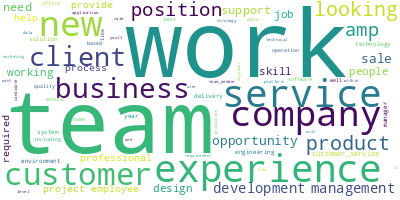

In [ ]:
# Generating visualization from final model

from wordcloud import WordCloud

n_words = len(final_lda.id2word)
topic_word_dist = final_lda.get_topics()

n_topics = final_lda.num_topics
topic_word_matrix = np.reshape(topic_word_dist, (n_topics, n_words))

top_words = []
for topic_probs in topic_word_matrix:
    word_idx = np.argsort(topic_probs)[::-1][:30]
    topic_words = [final_lda.id2word[i] for i in word_idx]
    top_words.append(topic_words)

wordcloud_dict = {}
for topic_words in top_words:
    for word in topic_words:
        wordcloud_dict[word] = wordcloud_dict.get(word, 0) + 1

wordcloud = WordCloud(background_color="white").generate_from_frequencies(wordcloud_dict)
wordcloud.to_image()

#### Use the dominant topic of description as feature



> We utilize the dominant topic generated by the model and save that as a feature for each observation in the data set. 



In [ ]:
dominant_topic = [max(final_lda.get_document_topics(corpus[i]), key=lambda x: x[1])[0] for i in range(len(X_train))]

In [ ]:
X_train['dominant_topic'] = dominant_topic
X_train.head()

department  function  industry  telecommuting  \
2597           0         0         0              0   
8235           0         1         1              0   
3539           0         0         0              0   
6656           1         1         1              0   
3828           0         0         0              0   

                                            description  has_company_logo  \
2597  Brand Manager is overall and final responsible...                 0   
8235  Just wanted to touch base with you regarding o...                 1   
3539  his is fantastic opportunity for someone wanti...                 1   
6656  Based in New York City, SumAll is a connected ...                 1   
3828  Offerial is a hospitality technology startup. ...                 1   

      has_questions  employment_type  required_experience  required_education  \
2597              1                0                    0                   0   
8235              0                3                    3                   9   
3539              0                0                    1                   5   
6656              0                5                    3                   9   
3828              1                0                    0                   0   

     minimum_salary_grp maximum_salary_grp  company_profile_length  \
2597                 -1                 -1               -1.083281   
8235                  0                  0                0.056597   
3539                 -1                 -1                0.456142   
6656                 -1                 -1               -0.319445   
3828                 -1                 -1                2.806406   

      description_length  requirements_length  benefits_length  \
2597           -0.700573            -0.252004         2.426989   
8235            0.624818             1.748425        -0.533685   
3539           -0.621338            -0.648129        -0.499057   
6656           -0.477274             1.332494         1.821003   
3828            0.711256             0.183733        -0.533685   

                                             clean_desc  dominant_topic  
2597  brand manager overall final responsible creati...              29  
8235  wanted touch base regarding one fast moving re...              26  
3539  fantastic opportunity someone wanting start ca...              24  
6656  based new york city sumall connected data tool...              29  
3828  offerial hospitality technology startup startu...               7

#### Preprocess the description texts in testing set

In [ ]:
X_test['clean_desc'] = X_test['description'].str.replace(r'[^\w\s]+', '')
X_test.clean_desc = X_test.clean_desc.apply(lambda text: remove_stopwords(text, STOPWORDS))
X_test.clean_desc = X_test.clean_desc.apply(lambda text: remove_stopwords(text, extended_stopwords))

In [ ]:
test_lemmatized_text = [[lemmatizer.lemmatize(word) for word in word_tokenize(text)] for text in X_test.clean_desc]

In [ ]:
test_bigram = models.Phrases(test_lemmatized_text)
test_bigram_mod = models.phrases.Phraser(test_bigram)
test_data_bigram = [test_bigram_mod[i] for i in test_lemmatized_text]
test_dictionary = Dictionary(test_data_bigram)
test_corpus= [test_dictionary.doc2bow(text) for text in test_data_bigram]

#### Get the dominant topic for testing set based on the trained LDA model

In [ ]:
test_dominant_topic = [max(final_lda.get_document_topics(test_corpus[i]), key=lambda x: x[1])[0] for i in range(len(X_test))]
X_test['dominant_topic'] = test_dominant_topic

#### Save the data



> Our data is saved so that it can be reloaded without running expensive operations in the previous processing sections. 



In [ ]:
X_train.drop(['description', 'clean_desc'], axis=1, inplace=True)
X_train.head()

department  function  industry  telecommuting  has_company_logo  \
2597           0         0         0              0                 0   
8235           0         1         1              0                 1   
3539           0         0         0              0                 1   
6656           1         1         1              0                 1   
3828           0         0         0              0                 1   

      has_questions  employment_type  required_experience  required_education  \
2597              1                0                    0                   0   
8235              0                3                    3                   9   
3539              0                0                    1                   5   
6656              0                5                    3                   9   
3828              1                0                    0                   0   

     minimum_salary_grp maximum_salary_grp  company_profile_length  \
2597                 -1                 -1               -1.083281   
8235                  0                  0                0.056597   
3539                 -1                 -1                0.456142   
6656                 -1                 -1               -0.319445   
3828                 -1                 -1                2.806406   

      description_length  requirements_length  benefits_length  dominant_topic  
2597           -0.700573            -0.252004         2.426989              29  
8235            0.624818             1.748425        -0.533685              26  
3539           -0.621338            -0.648129        -0.499057              24  
6656           -0.477274             1.332494         1.821003              29  
3828            0.711256             0.183733        -0.533685               7

In [ ]:
X_test.drop(['description', 'clean_desc'], axis=1, inplace=True)

In [ ]:
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")

In [ ]:
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

### Prediction



> This section details the construction of our final model to predict fraudulent job postings. We test and compare the success of multiple models. This project evluates performance for logistic regression, decision tree, random forest, and KNN appraoches. The best performing model is hypertuned for maximum effectiveness. 

Ultimately, we construct a random forest model optimized with the parameters for the highest average recall and highest average area under the ROC curve. 

In [ ]:
X_train = pd.read_csv("./X_train.csv", index_col=0)
X_test = pd.read_csv("./X_test.csv", index_col=0)
y_train = pd.read_csv("./y_train.csv", index_col=0)
y_test = pd.read_csv("./y_test.csv", index_col=0)

In [ ]:
# Setting dominant topic to be a cateogry for model construction

X_test['dominant_topic'] = X_test['dominant_topic'].astype('category')
X_train['dominant_topic'] = X_train['dominant_topic'].astype('category')

# Ensuring column orders are correct upon read_csv()

X_test = X_test[['department', 'function', 'industry', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'maximum_salary_grp',
       'minimum_salary_grp', 'company_profile_length', 'description_length',
       'requirements_length', 'benefits_length', 'dominant_topic']]
X_train = X_train[['department', 'function', 'industry', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'maximum_salary_grp',
       'minimum_salary_grp', 'company_profile_length', 'description_length',
       'requirements_length', 'benefits_length', 'dominant_topic']]

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5901 entries, 9064 to 660
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   department              5901 non-null   int64   
 1   function                5901 non-null   int64   
 2   industry                5901 non-null   int64   
 3   telecommuting           5901 non-null   int64   
 4   has_company_logo        5901 non-null   int64   
 5   has_questions           5901 non-null   int64   
 6   employment_type         5901 non-null   int64   
 7   required_experience     5901 non-null   int64   
 8   required_education      5901 non-null   int64   
 9   maximum_salary_grp      5901 non-null   int64   
 10  minimum_salary_grp      5901 non-null   int64   
 11  company_profile_length  5901 non-null   float64 
 12  description_length      5901 non-null   float64 
 13  requirements_length     5901 non-null   float64 
 14  benefits_length       

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11979 entries, 2597 to 12237
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   department              11979 non-null  int64   
 1   function                11979 non-null  int64   
 2   industry                11979 non-null  int64   
 3   telecommuting           11979 non-null  int64   
 4   has_company_logo        11979 non-null  int64   
 5   has_questions           11979 non-null  int64   
 6   employment_type         11979 non-null  int64   
 7   required_experience     11979 non-null  int64   
 8   required_education      11979 non-null  int64   
 9   maximum_salary_grp      11979 non-null  int64   
 10  minimum_salary_grp      11979 non-null  int64   
 11  company_profile_length  11979 non-null  float64 
 12  description_length      11979 non-null  float64 
 13  requirements_length     11979 non-null  float64 
 14  benefits_length    

In [ ]:
# Checking the class imbalance for setting the thresholds

value_counts = y_train.fraudulent.value_counts()

ratio = value_counts[1] / len(y_train)

print('The ratio of fraudulent to non-fraudulent is: %', ratio * 100)

The ratio of fraudulent to non-fraudulent is: % 4.841806494699057


##### Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Setting the weight to 'balanced' to adjust for the class imbalance
logreg = LogisticRegression(class_weight='balanced')

# Fitting the model to the data
logreg.fit(X_train, y_train.fraudulent)

# Predicting the target value for fraudulent
y_log_pred = logreg.predict(X_test)

# getting probabilities
y_log_prob = logreg.predict_proba(X_test)[:, 1]

In [ ]:
print('Accuracy:', accuracy_score(y_test.fraudulent, y_log_pred))
print('Precision:', precision_score(y_test.fraudulent, y_log_pred))
print('Recall:', recall_score(y_test.fraudulent, y_log_pred))
print('F1-Score:', f1_score(y_test.fraudulent, y_log_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, y_log_prob))

Accuracy: 0.7763091001525165
Precision: 0.13385269121813032
Recall: 0.6608391608391608
F1-Score: 0.2226148409893993
ROC-AUC Score: 0.8084171394055631


In [ ]:
# Tuning 

# Testing if regularization improves predictability

logreg2 = LogisticRegression(C=0.1, class_weight='balanced')

# Fit the model to the training data
logreg2.fit(X_train, y_train.fraudulent)

# Evaluate the model on the test data again
y_log_pred2 = logreg2.predict(X_test)

y_log_prob2 = logreg2.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test.fraudulent, y_log_pred2))
print('Precision:', precision_score(y_test.fraudulent, y_log_pred2))
print('Recall:', recall_score(y_test.fraudulent, y_log_pred2))
print('F1-Score:', f1_score(y_test.fraudulent, y_log_pred2))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, y_log_prob2))

Accuracy: 0.7754617861379427
Precision: 0.1333803810868031
Recall: 0.6608391608391608
F1-Score: 0.22196124486200824
ROC-AUC Score: 0.8082645760294915


In [ ]:
# Saving predictability scores of best model for graphing later

log_accuracy = accuracy_score(y_test.fraudulent, y_log_pred2)
log_percision = precision_score(y_test.fraudulent, y_log_pred2)
log_recall = recall_score(y_test.fraudulent, y_log_pred2)
log_f1 = f1_score(y_test.fraudulent, y_log_pred2)
log_roc = roc_auc_score(y_test.fraudulent, y_log_prob2)

In [ ]:
# Saving predictability scores of best model for graphing later

log_fpr, log_tpr, _ = roc_curve(y_test.fraudulent, y_log_pred2)
log_roc_auc = auc(log_fpr, log_tpr)

##### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Fitting a decision tree

dtree = DecisionTreeClassifier(random_state=0)

dtree.fit(X_train, y_train.fraudulent)

dtree_pred = dtree.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, dtree_pred))
print('Precision:', precision_score(y_test.fraudulent, dtree_pred))
print('Recall:', recall_score(y_test.fraudulent, dtree_pred))
print('F1-Score:', f1_score(y_test.fraudulent, dtree_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, dtree_pred))

Accuracy: 0.9489916963226572
Precision: 0.4742268041237113
Recall: 0.4825174825174825
F1-Score: 0.4783362218370884
ROC-AUC Score: 0.7276345204216976


In [ ]:
# Tuning

# Testing with class imbalance accounted for

dtree2 = DecisionTreeClassifier(class_weight='balanced')

dtree2.fit(X_train, y_train.fraudulent)

dtree_pred2 = dtree2.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, dtree_pred2))
print('Precision:', precision_score(y_test.fraudulent, dtree_pred2))
print('Recall:', recall_score(y_test.fraudulent, dtree_pred2))
print('F1-Score:', f1_score(y_test.fraudulent, dtree_pred2))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, dtree_pred2))

Accuracy: 0.95051686154889
Precision: 0.4891304347826087
Recall: 0.47202797202797203
F1-Score: 0.4804270462633452
ROC-AUC Score: 0.7234583315171027


In [ ]:
# Saving predictability scores of best model for graphing later

dtree_accuracy =  accuracy_score(y_test.fraudulent, dtree_pred2)
dtree_percision = precision_score(y_test.fraudulent, dtree_pred2)
dtree_recall = recall_score(y_test.fraudulent, dtree_pred2)
dtree_f1 = f1_score(y_test.fraudulent, dtree_pred2)
dtree_roc = roc_auc_score(y_test.fraudulent, dtree_pred2)


In [ ]:
# Saving predictability scores of best model for graphing later

dtree_fpr, dtree_tpr, _ = roc_curve(y_test.fraudulent, dtree_pred)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fitting the random forest classifier

rfor = RandomForestClassifier(class_weight='balanced')

# train the model on the training data
rfor.fit(X_train, y_train.fraudulent)

# predict the target variable on the test data
rfor_pred = rfor.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, rfor_pred))
print('Precision:', precision_score(y_test.fraudulent, rfor_pred))
print('Recall:', recall_score(y_test.fraudulent, rfor_pred))
print('F1-Score:', f1_score(y_test.fraudulent, rfor_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, rfor_pred))

Accuracy: 0.9684799186578547
Precision: 0.9032258064516129
Recall: 0.3916083916083916
F1-Score: 0.5463414634146342
ROC-AUC Score: 0.6947356294640356


In [ ]:
depths = [tree.tree_.max_depth for tree in rfor.estimators_]
print("Maximum tree depth: ", max(depths))

Maximum tree depth:  39


In [ ]:
# Tuning

# Changing the depth of the trees in the forest
rfor2 = RandomForestClassifier(class_weight='balanced', max_depth = 45)

# train the model on the training data
rfor2.fit(X_train, y_train.fraudulent)

# predict the target variable on the test data
rfor_pred2 = rfor.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, rfor_pred2))
print('Precision:', precision_score(y_test.fraudulent, rfor_pred2))
print('Recall:', recall_score(y_test.fraudulent, rfor_pred2))
print('F1-Score:', f1_score(y_test.fraudulent, rfor_pred2))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, rfor_pred2))

Accuracy: 0.9684799186578547
Precision: 0.9032258064516129
Recall: 0.3916083916083916
F1-Score: 0.5463414634146342
ROC-AUC Score: 0.6947356294640356


In [ ]:
# Saving predictability scores of best model for graphing later


rfor_accuracy = accuracy_score(y_test.fraudulent, rfor_pred2)
rfor_percision = precision_score(y_test.fraudulent, rfor_pred2)
rfor_recall = recall_score(y_test.fraudulent, rfor_pred2)
rfor_f1 = f1_score(y_test.fraudulent, rfor_pred2)
rfor_roc = roc_auc_score(y_test.fraudulent, rfor_pred2)


In [ ]:
# Saving predictability scores of best model for graphing later

rfor_fpr, for_tpr, _ = roc_curve(y_test.fraudulent, rfor_pred2)
rfor_roc_auc = auc(rfor_fpr, for_tpr)

##### K Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Fitting a K Nearest Neighbor Classifer

knn = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
knn.fit(X_train, y_train.fraudulent)

# Predict the labels of the test data
knn_y_pred = knn.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, knn_y_pred))
print('Precision:', precision_score(y_test.fraudulent, knn_y_pred))
print('Recall:', recall_score(y_test.fraudulent, knn_y_pred))
print('F1-Score:', f1_score(y_test.fraudulent, knn_y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, knn_y_pred))

Accuracy: 0.9417047957973225
Precision: 0.3231707317073171
Recall: 0.1853146853146853
F1-Score: 0.2355555555555556
ROC-AUC Score: 0.58277310401086


In [ ]:
from sklearn.model_selection import cross_val_score

# Choosing amongst the best number of neighbors

# Define range of k values to try
k_range = range(1, 15)

cv_scores = []

# Perform k-fold cross-validation for each k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train.fraudulent, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find best k
best_k = k_range[cv_scores.index(max(cv_scores))]

# Train final model using best k
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train.fraudulent)

knn_final_pred = final_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, knn_final_pred))
print('Precision:', precision_score(y_test.fraudulent, knn_final_pred))
print('Recall:', recall_score(y_test.fraudulent, knn_final_pred))
print('F1-Score:', f1_score(y_test.fraudulent, knn_final_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, knn_final_pred))

Accuracy: 0.942721572614811
Precision: 0.3088235294117647
Recall: 0.14685314685314685
F1-Score: 0.1990521327014218
ROC-AUC Score: 0.5650561370953179


In [ ]:
# Saving final predictability scores

knn_accuracy = accuracy_score(y_test.fraudulent, knn_final_pred)
knn_percision = precision_score(y_test.fraudulent, knn_final_pred)
knn_recall = recall_score(y_test.fraudulent, knn_final_pred)
knn_f1 = f1_score(y_test.fraudulent, knn_final_pred)
knn_roc = roc_auc_score(y_test.fraudulent, knn_final_pred)


In [ ]:
knn_fpr, knn_tpr, _ = roc_curve(y_test.fraudulent, knn_final_pred)
knn_roc_auc = auc(knn_fpr, knn_tpr)

##### SMOTE Random Forest

Synthetic Minority Oversampling Technique

In [ ]:
X_test_smote = X_test.dropna(how='all').astype('float')

X_train_smote = X_train.dropna(how='all').astype('float')

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Setting up the oversampling

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train.fraudulent)

counter = Counter(y_train_resampled)
print(counter)

Counter({0: 11399, 1: 11399})


In [ ]:
# fitting a new random forest

smote_rf = RandomForestClassifier(random_state=42)

smote_rf.fit(X_train_resampled, y_train_resampled)

smote_pred = smote_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, smote_pred))
print('Precision:', precision_score(y_test.fraudulent, smote_pred))
print('Recall:', recall_score(y_test.fraudulent, smote_pred))
print('F1 score:', f1_score(y_test.fraudulent, smote_pred))
print('ROC AUC score:', roc_auc_score(y_test.fraudulent, smote_pred))

Accuracy: 0.9628876461616676
Precision: 0.6425531914893617
Recall: 0.527972027972028
F1 score: 0.579654510556622
ROC AUC score: 0.756506049604892


In [ ]:
# Preserving results for graph

smote_accuracy = accuracy_score(y_test.fraudulent, smote_pred)
smote_percision = precision_score(y_test.fraudulent, smote_pred)
smote_recall = recall_score(y_test.fraudulent, smote_pred)
smote_f1 = f1_score(y_test.fraudulent, smote_pred)
smote_roc = roc_auc_score(y_test.fraudulent, smote_pred)

In [ ]:
# Preserving results for graph

smote_fpr, smote_tpr, _ = roc_curve(y_test.fraudulent, smote_pred)
smote_roc_auc = auc(smote_fpr, smote_tpr)

#### Comparing Outcomes


In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

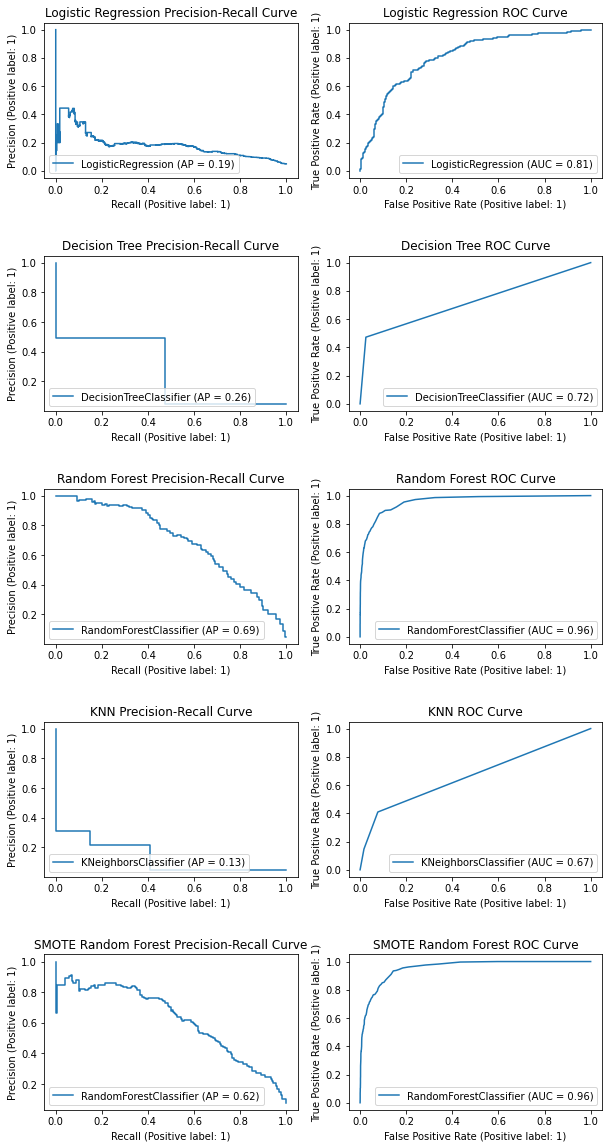

In [ ]:
models = [logreg2, dtree2, rfor2, final_model, smote_rf]
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SMOTE Random Forest']

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# Loop over the models and plot their curves
for i, model in enumerate(models):
    
    # Plot the precision-recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test.fraudulent, ax=axs[i, 0])
    axs[i, 0].set_title(labels[i] + " Precision-Recall Curve")
    
    # Plot the ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test.fraudulent, ax=axs[i, 1])
    axs[i, 1].set_title(labels[i] + " ROC Curve")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

In [ ]:
recalls = [log_recall, dtree_recall, rfor_recall, knn_recall, smote_recall]
accuracies = [log_accuracy, dtree_accuracy, rfor_accuracy, knn_accuracy, smote_accuracy] 
f1s = [log_f1, dtree_f1, rfor_f1, knn_f1, smote_f1] 
auc_all = [log_roc_auc, dtree_roc_auc, rfor_roc_auc, knn_roc_auc, smote_roc_auc]
fps =[log_fpr[1], dtree_fpr[1], rfor_fpr[1], knn_fpr[1], smote_fpr[1]]
tps = [log_tpr[1], dtree_tpr[1], for_tpr[1], knn_tpr[1], smote_tpr[1]]
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SMOTE Random Forest']

d = {'Model':labels, 'Recall':recalls, 'Accuracy': accuracies, 'F1': f1s, 'False Positive Rate':fps, 'True Postive Rate': tps, 'Area Under Curve': auc_all}

outcomes = pd.DataFrame(d)

In [ ]:
alt.Chart(outcomes).mark_circle(size=100).encode(
    x = alt.X('Recall', axis=alt.Axis(title='Recall')),
    y = alt.Y('Accuracy', axis=alt.Axis(title='Accuracy')),
    color = alt.Color('Model', legend=alt.Legend(title='Model')),
    tooltip = [alt.Tooltip('Model'), alt.Tooltip('F1', format='.3f')]
)

alt.Chart(...)

In [ ]:
outcomes

Model    Recall  Accuracy        F1  False Positive Rate  \
0  Logistic Regression  0.660839  0.775462  0.221961             0.218700   
1        Decision Tree  0.472028  0.950517  0.480427             0.027248   
2        Random Forest  0.391608  0.968480  0.546341             0.002137   
3                  KNN  0.146853  0.942722  0.199052             0.016741   
4  SMOTE Random Forest  0.527972  0.962888  0.579655             0.014960   

   True Postive Rate  Area Under Curve  
0           0.660839          0.721070  
1           0.482517          0.727635  
2           0.391608          0.694736  
3           0.146853          0.565056  
4           0.527972          0.756506

### Model Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Create the random grid
random_grid = {'criterion': ["gini", "entropy", "log_loss"],
               'max_features': ["sqrt", "log2", None],
               'max_depth': [10, 15, 20, 25, 30, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = smote_rf, 
                               param_distributions = random_grid, 
                               scoring = ["recall", "roc_auc"],
                               n_iter = 100, 
                               cv = 4, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1,
                               refit = False)

Tune SMOTE Random Forest model for recall and roc_auc

In [ ]:
rf_random.fit(X_train_resampled, y_train_resampled)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 15, 20, 25, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, refit=False, scoring=['recall', 'roc_auc'],
                   verbose=2)

Get the best parameters considering both recall and roc_auc metrics

In [ ]:
rf_random_results = rf_random.cv_results_

In [ ]:
rf_random_bestid_recall = np.argsort(rf_random_results['rank_test_recall'])[:5]
rf_random_bestid_roc_auc = np.argsort(rf_random_results['rank_test_roc_auc'])[:5]

In [ ]:
rf_random_bestid = np.concatenate((rf_random_bestid_recall, rf_random_bestid_roc_auc))
rf_random_mean_test_recall = rf_random_results['mean_test_recall'][rf_random_bestid]
rf_random_mean_test_roc_auc = rf_random_results['mean_test_roc_auc'][rf_random_bestid]
rf_random_compare = pd.DataFrame({'index': rf_random_bestid, 'recall': rf_random_mean_test_recall, 'roc_auc': rf_random_mean_test_roc_auc})

In [ ]:
rf_random_compare

index    recall   roc_auc
0     25  0.989561  0.998729
1     17  0.988245  0.998237
2     48  0.988245  0.998237
3     72  0.988070  0.999050
4     19  0.987982  0.999124
5     70  0.986842  0.999334
6     49  0.986930  0.999333
7     30  0.987017  0.999315
8     14  0.987193  0.999276
9     78  0.986140  0.999249

In [ ]:
import seaborn as sns

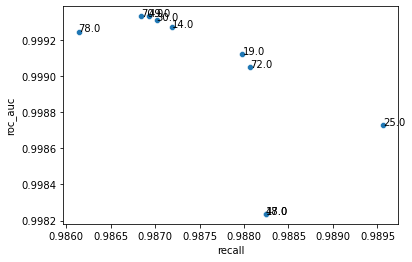

In [ ]:
ax = sns.scatterplot(x = rf_random_compare.recall, y = rf_random_compare.roc_auc)
for i, row in rf_random_compare.iterrows():
    ax.text(row[1], row[2], row[0])

In [ ]:
rf_random_best_params = rf_random_results['params'][25]

Tune Random Forest model for recall and roc_auc

In [ ]:
rf_random2 = RandomizedSearchCV(estimator = rfor2, 
                               param_distributions = random_grid, 
                               scoring = ["recall", "roc_auc"],
                               n_iter = 100, 
                               cv = 4, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1,
                               refit = False)
rf_random2.fit(X_train, y_train.fraudulent)
rf_random2_results = rf_random2.cv_results_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


Get the best parameters considering both recall and roc_auc metrics

In [ ]:
rf_random2_bestid_recall = np.argsort(rf_random2_results['rank_test_recall'])[:5]
rf_random2_bestid_roc_auc = np.argsort(rf_random2_results['rank_test_roc_auc'])[:5]
rf_random2_bestid = np.concatenate((rf_random2_bestid_recall, rf_random2_bestid_roc_auc))
rf_random2_mean_test_recall = rf_random2_results['mean_test_recall'][rf_random2_bestid]
rf_random2_mean_test_roc_auc = rf_random2_results['mean_test_roc_auc'][rf_random2_bestid]
rf_random2_compare = pd.DataFrame({'index': rf_random2_bestid, 'recall': rf_random2_mean_test_recall, 'roc_auc': rf_random2_mean_test_roc_auc})

In [ ]:
rf_random2_compare

index    recall   roc_auc
0     91  0.775862  0.876396
1     32  0.772414  0.958717
2     83  0.765517  0.867022
3     64  0.762069  0.955762
4     28  0.734483  0.949801
5     67  0.481034  0.971865
6      7  0.532759  0.971652
7     36  0.527586  0.971533
8     14  0.620690  0.971300
9     78  0.589655  0.971285

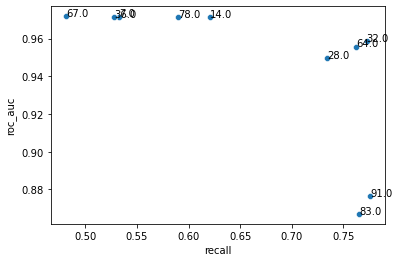

In [ ]:
ax2 = sns.scatterplot(x = rf_random2_compare.recall, y = rf_random2_compare.roc_auc)
for i, row in rf_random2_compare.iterrows():
    ax2.text(row[1], row[2], row[0])

In [ ]:
rf_random2_best_params = rf_random2_results['params'][32]

Retrain the models

parameters with high mean_test_recall and mean_test_roc_auc

In [ ]:
# Fitting the random forest classifier

tuned_smote_rf = RandomForestClassifier(**rf_random_best_params)

# train the model on the training data
tuned_smote_rf.fit(X_train_resampled, y_train_resampled)

# predict the target variable on the test data
tuned_smote_rf_pred = tuned_smote_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, tuned_smote_rf_pred))
print('Precision:', precision_score(y_test.fraudulent, tuned_smote_rf_pred))
print('Recall:', recall_score(y_test.fraudulent, tuned_smote_rf_pred))
print('F1-Score:', f1_score(y_test.fraudulent, tuned_smote_rf_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, tuned_smote_rf_pred))

Accuracy: 0.9518725639722081
Precision: 0.5028089887640449
Recall: 0.6258741258741258
F1-Score: 0.5576323987538941
ROC-AUC Score: 0.7971757094196987


In [ ]:
# fitting a new random forest

tuned_rf = RandomForestClassifier(**rf_random2_best_params)

tuned_rf.fit(X_train, y_train.fraudulent)

tuned_rf_pred = tuned_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, tuned_rf_pred))
print('Precision:', precision_score(y_test.fraudulent, tuned_rf_pred))
print('Recall:', recall_score(y_test.fraudulent, tuned_rf_pred))
print('F1 score:', f1_score(y_test.fraudulent, tuned_rf_pred))
print('ROC AUC score:', roc_auc_score(y_test.fraudulent, tuned_rf_pred))

Accuracy: 0.9620403321470937
Precision: 0.9558823529411765
Recall: 0.22727272727272727
F1 score: 0.3672316384180791
ROC AUC score: 0.6133692220513235


parameters with highest recall

In [ ]:
tuned = RandomForestClassifier(**rf_random_results['params'][rf_random_results['rank_test_recall'].argmin()])
# train the model on the training data
tuned.fit(X_train_resampled, y_train_resampled)

# predict the target variable on the test data
tuned_pred = tuned.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, tuned_pred))
print('Precision:', precision_score(y_test.fraudulent, tuned_pred))
print('Recall:', recall_score(y_test.fraudulent, tuned_pred))
print('F1-Score:', f1_score(y_test.fraudulent, tuned_pred))
print('ROC-AUC Score:', roc_auc_score(y_test.fraudulent, tuned_pred))

Accuracy: 0.9515336383663786
Precision: 0.5
Recall: 0.6118881118881119
F1-Score: 0.550314465408805
ROC-AUC Score: 0.7903607968167184


In [ ]:
tuned1 = RandomForestClassifier(**rf_random2_results['params'][rf_random2_results['rank_test_recall'].argmin()])

tuned1.fit(X_train, y_train.fraudulent)

tuned1_pred = tuned1.predict(X_test)

print('Accuracy:', accuracy_score(y_test.fraudulent, tuned1_pred))
print('Precision:', precision_score(y_test.fraudulent, tuned1_pred))
print('Recall:', recall_score(y_test.fraudulent, tuned1_pred))
print('F1 score:', f1_score(y_test.fraudulent, tuned1_pred))
print('ROC AUC score:', roc_auc_score(y_test.fraudulent, tuned1_pred))

Accuracy: 0.9518725639722081
Precision: 0.505
Recall: 0.3531468531468531
F1 score: 0.41563786008230447
ROC AUC score: 0.6677577542671042


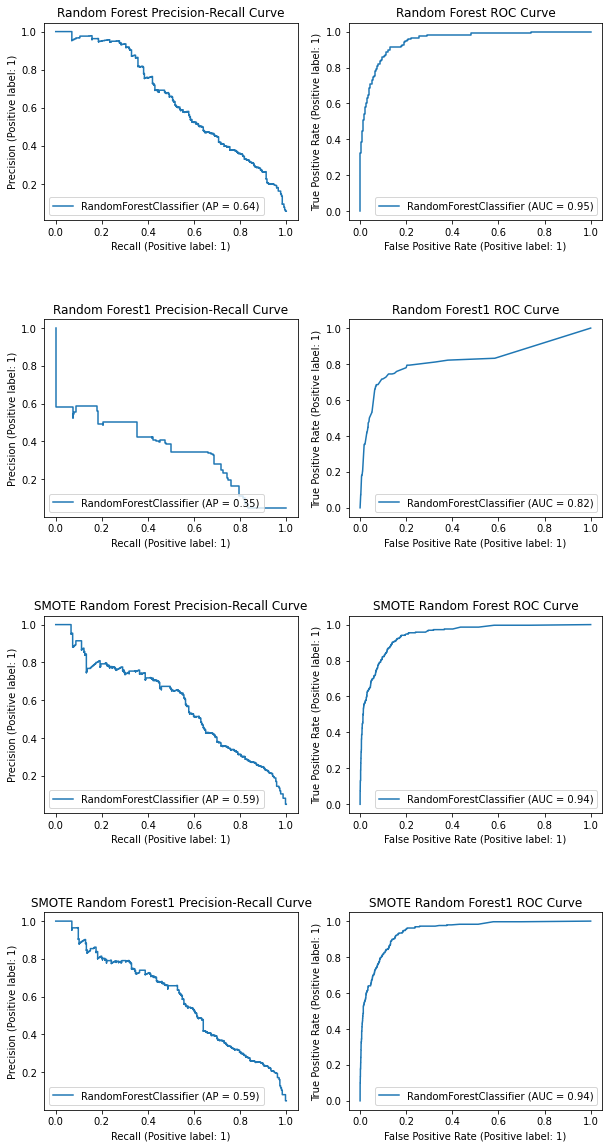

In [ ]:
models = [tuned_rf, tuned1, tuned_smote_rf, tuned]
labels = ['Random Forest', 'Random Forest1', 'SMOTE Random Forest', 'SMOTE Random Forest1']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

# Loop over the models and plot their curves
for i, model in enumerate(models):
    
    # Plot the precision-recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test.fraudulent, ax=axs[i, 0])
    axs[i, 0].set_title(labels[i] + " Precision-Recall Curve")
    
    # Plot the ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test.fraudulent, ax=axs[i, 1])
    axs[i, 1].set_title(labels[i] + " ROC Curve")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

### Save Models

In [ ]:
import pickle

In [ ]:
with open('lda.model', 'wb') as f:
    pickle.dump(final_lda, f)


In [ ]:
with open('smote_rf.model', 'wb') as f:
    pickle.dump(tuned_smote_rf, f)